In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from tensorflow.keras.preprocessing.sequence import pad_sequences

C:\Users\Mathias\Anaconda3\envs\pd\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Mathias\Anaconda3\envs\pd\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Mathias\Anaconda3\envs\pd\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Mathias\Anaconda3\envs\pd\lib\site-packages\tensorflow\python\frame

In [2]:

root = Path(r'C:\Users\Mathias\repos\habitual_errors_NLP\data\MJFF\preproc\char_time' )

df = pd.read_csv(root / 'EnglishData-preprocessed_attempt_1.csv')
folds = pd.read_csv(root / 'EnglishData-preprocessed_attempt_1_fold.csv')

with open(root / 'EnglishData-preprocessed_attempt_1_char2idx.json') as json_file:
    char2idx = json.load(json_file)

    
df = df.merge(folds , on = ['Participant_ID', 'Sentence_ID'])

In [3]:
def reduce_input(x):
    '''
    Refactor this method.. very very fast hack.
    '''
    single_char = []
    pre = '*'
    segment_list = []
    segment = []
    for i in range(0,len(x)):
        current = x[i]
        if current != pre:
            single_char.append(current)
            segment_list.append(segment)
            segment = []
        pre = current
        segment.append(current)
    segment_list.append(segment)
    del segment_list[0]
    
    count_list = [len(s) for s in segment_list]

    return single_char, count_list

def proc_frame(df):

    SINGLE_CHAR = []
    COUNT_LIST = []
    for idx, row in df.iterrows():
        
        single_char, count_list = reduce_input(row.Preprocessed_typed_sentence)
        SINGLE_CHAR.append(single_char)
        COUNT_LIST.append(count_list)
        
    df['single_char'] = SINGLE_CHAR
    df['count_list'] = COUNT_LIST


def mk_dataset(df, char2idx):
    
    pad_len = df.single_char.apply(lambda x: len(x)).max()
    channels = len(char2idx) + 1
    X = []
    y = df.Diagnosis.values
    for idx, row in df.iterrows():
        
        single_char = row.single_char
        count_list = row.count_list
        x = np.zeros((len(single_char),channels))
        for i, char in enumerate(single_char):
             x[i,char2idx[char]] = 1
        
        x[:,-1] = count_list
        X.append(x)
    return np.asarray(X),y

In [4]:
proc_frame(df)
df.count_list = df.count_list.apply(lambda x: np.asarray(x))

In [5]:

for grp , data in df.groupby(by = 'Participant_ID'):
    mean = np.concatenate(data.count_list.values).mean()
    std = np.concatenate(data.count_list.values).std()
    df.loc[data.index, 'count_list'] = (data.count_list - mean) / std


In [6]:
X,y  = mk_dataset(df,char2idx)

In [7]:
X = pad_sequences(X, maxlen=None, dtype='float16')

In [8]:

# simple global mean scale of duration
#mn= np.mean(X[:,:,-1],)
#X[:,:,-1] = X[:,:,-1] / mn


# Models

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Input, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

callbacks  = [EarlyStopping(verbose = 1, patience = 6, restore_best_weights= True)]
def mk_lstm_model():
    model = Sequential()

    inputs = Input(shape=(164,45))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # try using different optimizers and different optimizer configs
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

def mk_cnn_model():
    model = Sequential()
    model.add(Input(shape=(164,45)))
    model.add(Conv1D(filters = 128, kernel_size = 3, strides= 1, padding='valid',  activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters = 64, kernel_size = 3, strides= 1, padding='valid',  activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters = 64, kernel_size = 3, strides= 1, padding='valid',  activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model
    

In [10]:
#X=X[:,:,-1][:,:,None]

In [11]:
#for i in range(len(X)):
#    np.random.shuffle(X[i])

In [12]:
y_true = []
y_pred = []

for fold_idx in sorted(df.fold.unique()):
    print('Evaluating fold: {}'.format(fold_idx))
    test_mask = df.fold == fold_idx
    
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    X_train = X[~test_mask]
    y_train = y[~test_mask]
    
    
    model = mk_lstm_model()
    model.fit(X_train,y_train, callbacks = callbacks,validation_split = 0.1, epochs = 100, verbose = 0)

    pred = model.predict(X_test)
    
    y_true.append(y_test)
    y_pred.append(pred)
    

Evaluating fold: 0
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Evaluating fold: 1
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Evaluating fold: 2
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Evaluating fold: 3
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Evaluating fold: 4
Res

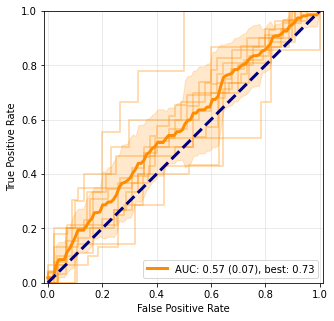

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

lw = 3
plt.figure(figsize = (5,5))
plt.axis('equal')
plt.grid(True, alpha = 0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
AUC = []
interp_tpr = []
x = np.linspace(0,1,100)
for y_t,y_p in zip(y_true,y_pred):

    #print(df['Patient_ID'].unique())
    fpr, tpr, _ = roc_curve(y_t, y_p)
    interp_tpr.append(np.interp(x,xp=fpr,fp=tpr))
    roc_auc = auc(fpr, tpr)
    AUC.append(roc_auc)
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw -1, alpha = 0.3)

mean = np.mean(interp_tpr,axis=0)
std = np.std(interp_tpr,axis = 0)

plt.plot(x, mean , color = 'darkorange', lw=lw, label = 'AUC: {:.2f} ({:.2f}), best: {:.2}'.format(np.mean(AUC),np.std(AUC),np.max(AUC)))
plt.fill_between(x,mean + std, mean - std, alpha = 0.2, color = 'darkorange')    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('MJFF subject lvl 10-fold')
plt.legend(loc="lower right")
plt.savefig('MJFF_ENG_kfold_SIMPLE_LSTM_STD.pdf')
plt.show()